# Dataiku Technical Challenge


## 0. Imports and Global Variables


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

DATA_PATH = "us_census_full/"
TRAIN_PATH = "".join([DATA_PATH, "census_income_learn.csv"])
TEST_PATH = "".join([DATA_PATH, "census_income_test.csv"])
METADATA_PATH = "".join([DATA_PATH, "census_income_metadata.txt"])

palette = ["#00B2A9", "#FFC14D", "#012A4A", "#F07167", "#C8B6FF"]

## 1. Import and Explore Data


### 1.1 Load the metadata and import the dataset

In [2]:
# Get metadata
try:
    with open(METADATA_PATH, "r") as file:
        metadata = file.read()
except FileNotFoundError:
    raise FileNotFoundError(f"The file at {METADATA_PATH} was not found.")
except Exception as e:
    raise Exception(f"An error occurred: {e}")

# Extract and rename the column names
lines = metadata.split("\n")
start_index = 142
column_names = []
continuous_columns = []
categorical_columns = []

for line in lines[start_index:]:
    # Ignore empty lines or lines not containing column descriptions
    if ":" not in line or line.startswith("|"):
        continue
    # Extract the column name part before the colon
    column_name = line.split(":")[0].strip()
    # Replace spaces with underscores
    column_name = column_name.replace(" ", "_")
    column_names.append(column_name)

    # Get continuous or categorical columns
    if "continuous." in line:
        continuous_columns.append(column_name)
    else:
        categorical_columns.append(column_name)

column_names.append("income")

In [3]:
# Do not consider instance_weight
train_raw_df = pd.read_csv(TRAIN_PATH, names=column_names).drop("instance_weight", axis=1)
test_raw_df = pd.read_csv(TEST_PATH, names=column_names).drop("instance_weight", axis=1)
column_names.remove("instance_weight")
continuous_columns.remove("instance_weight")

### 1.2 Numerical description

Let's see the repartition of the target variable in our dataset. Indeed we want to predict whether a person is making more or less than $50,000 per year. 

In [4]:
# Study the distribution of the target variable
total_individuals = len(train_raw_df["income"])
more_50 = len(train_raw_df[train_raw_df["income"] == " 50000+."]) / total_individuals * 100
less_50 = len(train_raw_df[train_raw_df["income"] == " - 50000."]) / total_individuals * 100

print(f"{more_50:.2f}% earn more than 50k per year in the dataset, so {less_50:.2f}% earn less than 50k.")

6.21% earn more than 50k per year in the dataset, so 93.79% earn less than 50k.


Let's see what the majority - earning less than 50k - looks like:

In [5]:
train_raw_df[train_raw_df["income"] == " - 50000."].describe(include="object")

,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,...,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veteran's_admin,income
count,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141,...,187141,187141,187141,187141,187141,187141,187141,187141,187141,187141
unique,9,17,3,7,24,15,5,10,2,3,...,10,3,4,5,43,43,43,5,3,1
top,Not in universe,Children,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,...,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe,- 50000.
freq,99341,47422,174591,85368,99778,99778,156093,160140,101321,170311,...,93153,94669,93153,131852,148861,150091,165840,165843,185388,187141


Let's see what the minority - earning more than 50k - looks like:

In [6]:
train_raw_df[train_raw_df["income"] == " 50000+."].describe(include="object")

,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,...,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veteran's_admin,income
count,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382,...,12382,12382,12382,12382,12382,12382,12382,12382,12382,12382
unique,9,16,3,7,24,15,5,10,2,3,...,9,3,4,2,42,42,42,5,3,1
top,Private,Bachelors degree(BA AB BS),Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Executive admin and managerial,White,All other,Male,Not in universe,...,?,Not in universe under 1 year old,?,Not in universe,United-States,United-States,United-States,Native- Born in the United States,Not in universe,50000+.
freq,7322,3915,12352,9600,1494,3593,11272,11767,9719,10148,...,6543,6543,6543,12380,10302,10388,11149,11149,12151,12382


The majority earning less than 50k is composed of children, so many categories are defined by *Not in Universe*, they are in majority composed of white, female and Native-Born in the United States (as well as their parents). The majority earning more than 50k is composed of people working in a private sector, having a Bachelors degree, white, male and Native-Born in the United States (and their mother and father as well).

Let's see what the continuous features can tell us about the whole dataset:

In [7]:
# Describe makes more sense for continuous features 
train_raw_df[continuous_columns].describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,23.174897
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,24.411488
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,52.000000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,52.000000


From this, we notice that this dataset is composed of people of average ~34 year old, earning ~55 dollars per hour and working in average 23 weeks per year. Let's dive a bit into those numbers to see what is behind.

### 1.3 Graphical Descriptions

#### Repartition of the income category 

Let's visualise the unbalanced income distribution to have a better view.

<Axes: xlabel='income', ylabel='Percent'>

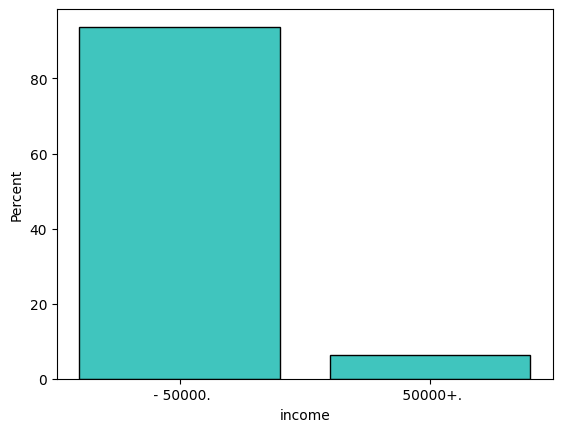

In [8]:
# Calculate the counts of each income category
sns.histplot(data=train_raw_df, x="income", stat="percent", discrete=True, shrink=.8, color=palette[0])

#### Income regarding age

Let's visualise the age repartition in the dataset, and let's highlight the income category to help us understand.

/var/folders/cv/ymhktwm96wd7ygk2lpb670mr0000gn/T/ipykernel_68864/107540606.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.displot(train_raw_df, x="age", bins=age_range_5, hue="income", palette=palette,


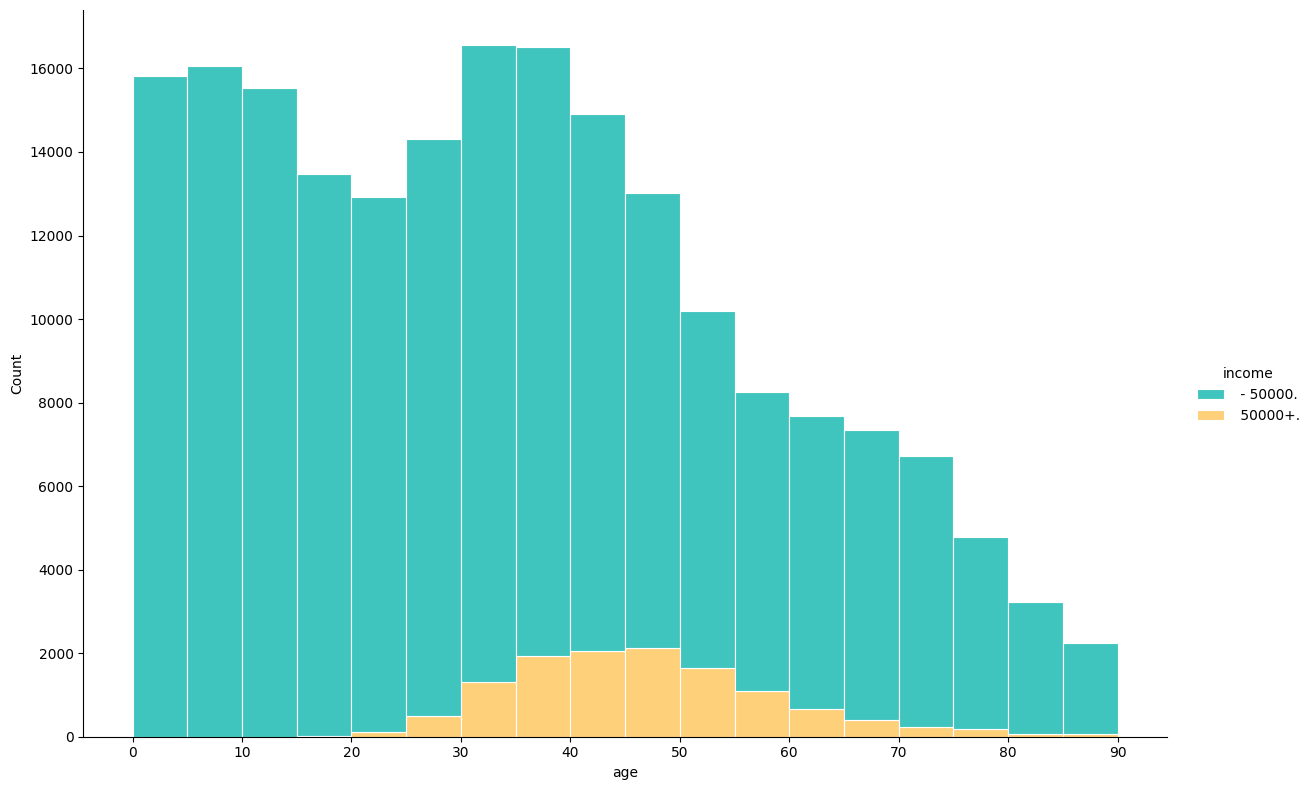

In [10]:
# make group of ages spaced by 5 years
age_range_5 = list(range(train_raw_df["age"].min(), train_raw_df["age"].max()+1, 5))

sns.displot(train_raw_df, x="age", bins=age_range_5, hue="income", palette=palette,
            multiple="stack", edgecolor="white", linewidth=0.8, height=8, aspect=1.5)
plt.xticks(range(0, max(train_raw_df["age"]) + 10, 10))
plt.show()

We notice that the distribution of people earning more than 50'000$ is centered around 45 year old which is higher than for the people earning less than 50'000$.
We also see a dip in population around 20-25 years old.

### Sex and income

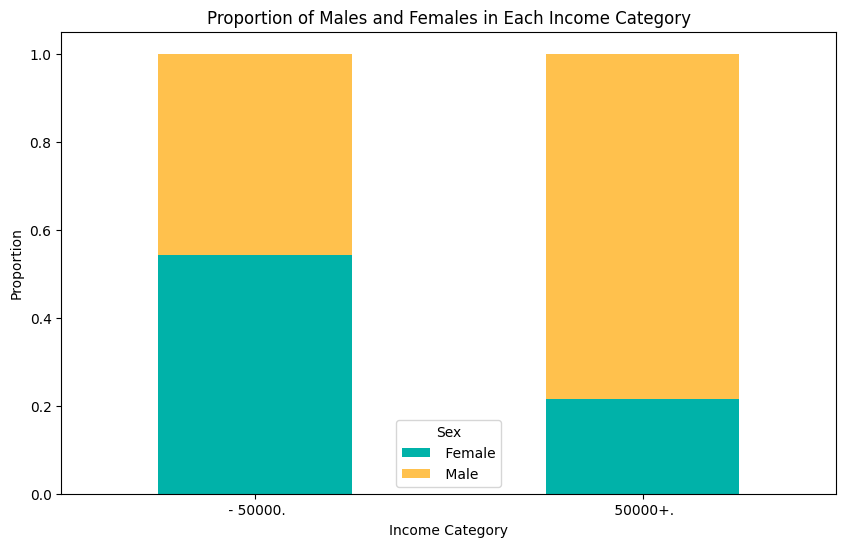

In [11]:
proportion_data = (
    train_raw_df.groupby(["income", "sex"])
    .size()  
    .unstack()  
    .apply(lambda x: x / x.sum(), axis=1)  
)

# bar char for sex distribution
proportion_data.plot(kind='bar', stacked=True, color=palette, figsize=(10, 6))

plt.title("Proportion of Males and Females in Each Income Category")
plt.xlabel("Income Category")
plt.ylabel("Proportion")
plt.legend(title="Sex")
plt.xticks(rotation=0)

plt.show()

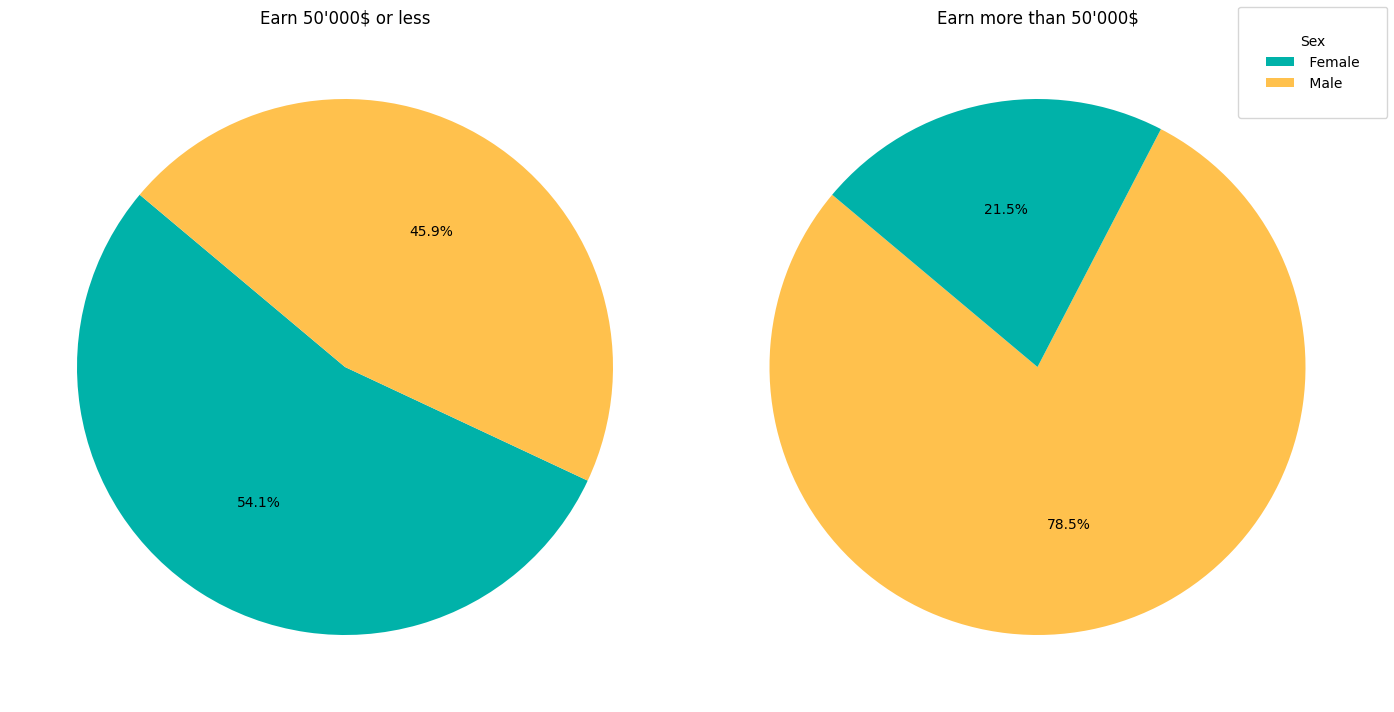

In [12]:
# Filter the DataFrame for each income category
less_than_50k_df = train_raw_df[train_raw_df["income"] == " - 50000."]
more_than_50k_df = train_raw_df[train_raw_df["income"] == " 50000+."]

# Calculate the counts 
sex_counts_less_than_50k = less_than_50k_df["sex"].value_counts()
sex_counts_more_than_50k = more_than_50k_df["sex"].value_counts()

plt.figure(figsize=(14, 7))

# Pie chart for income less than or equal to 50K
plt.subplot(1, 2, 1)  
plt.pie(sex_counts_less_than_50k, autopct='%1.1f%%', startangle=140, colors=[palette[0], palette[1]])
plt.title("Earn 50'000$ or less")

# Pie chart for income more than 50K
plt.subplot(1, 2, 2)  
plt.pie(sex_counts_more_than_50k, autopct='%1.1f%%', startangle=140, colors=[palette[1],palette[0]])
plt.title("Earn more than 50'000$")

plt.figlegend(sex_counts_less_than_50k.index, loc="upper right", title="Sex", borderpad=2)
plt.tight_layout()

plt.savefig("figures/distribution_sex.png", dpi=300)
plt.show()

For the income lower than 50'000$, we have a balanced sex distribution. But for an income higher than 50'000$, we have a significantly higher male population.

#### Race regarding outcome

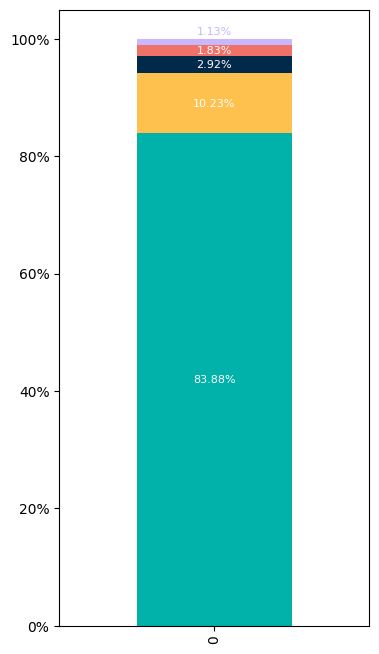

In [13]:
# Get data
proportion_data = (
    pd.DataFrame(train_raw_df.groupby(["race"]).count()["age"])
    .sort_values(by="age", ascending=False)
    .T
)
proportion_data = proportion_data / len(train_raw_df) * 100
proportion_data = proportion_data.reset_index().drop(["index"], axis=1)

# Plot
ax = proportion_data.plot(
    kind="bar", stacked=True, color=palette, figsize=(4, 8), legend=False
)

# Add percentage values on the middle of each stacked color with two decimal places
for i, container in enumerate(ax.containers):
    color = palette[i] if i > 3 else "white"
    padding = 8 if i > 3 else 0
    ax.bar_label(
        container,
        label_type="center",
        fmt=lambda x: f"{x:.2f}%",
        color=color,
        padding=padding,
        fontsize=8,
    )

plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.savefig("figures/race_stacked.png", format="png", dpi=300)
plt.show()

We notice that our distribution is mostly composed of white population (83.88%). It would be interesting to see if inside the distributions we have a different repartition of income class.

/var/folders/cv/ymhktwm96wd7ygk2lpb670mr0000gn/T/ipykernel_68864/2278840632.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0%}".format(x) for x in ticks])
/var/folders/cv/ymhktwm96wd7ygk2lpb670mr0000gn/T/ipykernel_68864/2278840632.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0%}".format(x) for x in ticks])
/var/folders/cv/ymhktwm96wd7ygk2lpb670mr0000gn/T/ipykernel_68864/2278840632.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["{:,.0%}".format(x) for x in ticks])
/var/folders/cv/ymhktwm96wd7ygk2lpb670mr0000gn/T/ipykernel_68864/2278840632.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

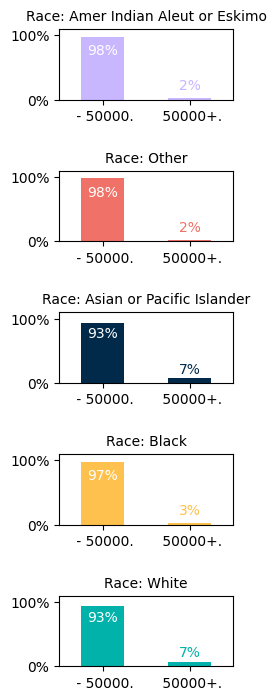

In [14]:
# Initialize subplots
fig, axs = plt.subplots(len(proportion_data.columns), 1, figsize=(3, len(proportion_data.columns) * 1.5))
fig.tight_layout(pad=3.0)

for i, race in enumerate(list(proportion_data.columns)[::-1]):
    # Filter the dataframe for the current race
    race_data = train_raw_df[train_raw_df["race"] == race]

    # Calculate the proportion of each income category within the current race
    income_proportion = race_data.groupby("income")["age"].count() / len(race_data)
    income_proportion = round(income_proportion, 2).to_frame(name="proportion")

    # Plotting on the ith subplot
    ax = axs[i]
    income_proportion.plot(kind="bar", color=palette[-(i+1)], ax=ax, legend=None)
    ax.set_xticklabels(income_proportion.index, rotation=0)
    ax.set_ylim([0, 1.1])

    # Format y-axis labels as percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(["{:,.0%}".format(x) for x in ticks])

    # Remove the x-axis label
    ax.set_xlabel('')

    # Annotate bars with percentage values
    for index, proportion in enumerate(income_proportion["proportion"]):
        ax.text(
            index,
            0.7 if index == 0 else 0.15,
            "{:,.0%}".format(proportion),
            ha="center",
            color="white" if index == 0 else palette[-(i+1)],
        )

    # Title
    ax.set_title(f"Race:{race}", fontsize=10)

plt.savefig('figures/race_multiple.png', format='png', dpi=300)
plt.show()

We notice that White and Asian/Pacific have a higher proportion of population with high income (7% vs. 2-3%).

#### Income regarding industry sectors

<Axes: xlabel='major_industry_code'>

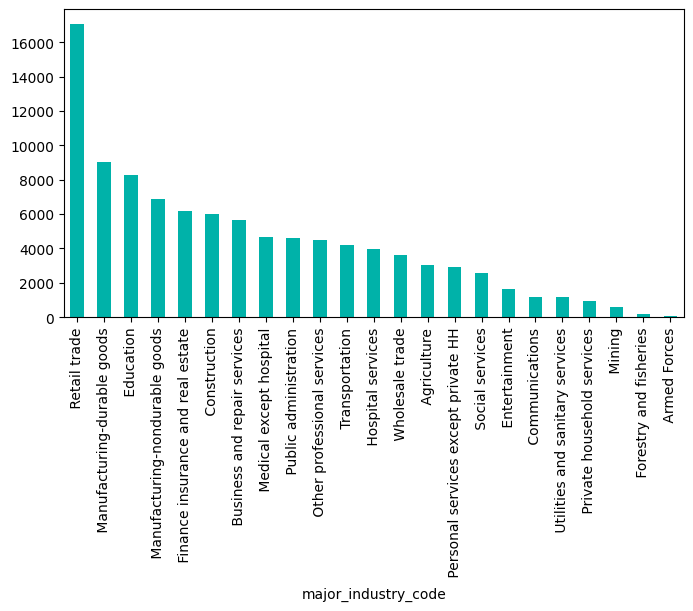

In [15]:
proportion_data = (
    pd.DataFrame(
        train_raw_df[
            train_raw_df["major_industry_code"] != " Not in universe or children"
        ]
        .groupby(["major_industry_code"])
        .count()["age"]
    )
    .sort_values(by="age", ascending=False)
)

proportion_data.plot(kind="bar", stacked=True, color=palette, figsize=(8, 4), legend=False)

We visualise the sectors where people work the most for. Let's see inside the income revenue category which industries are the most represented:

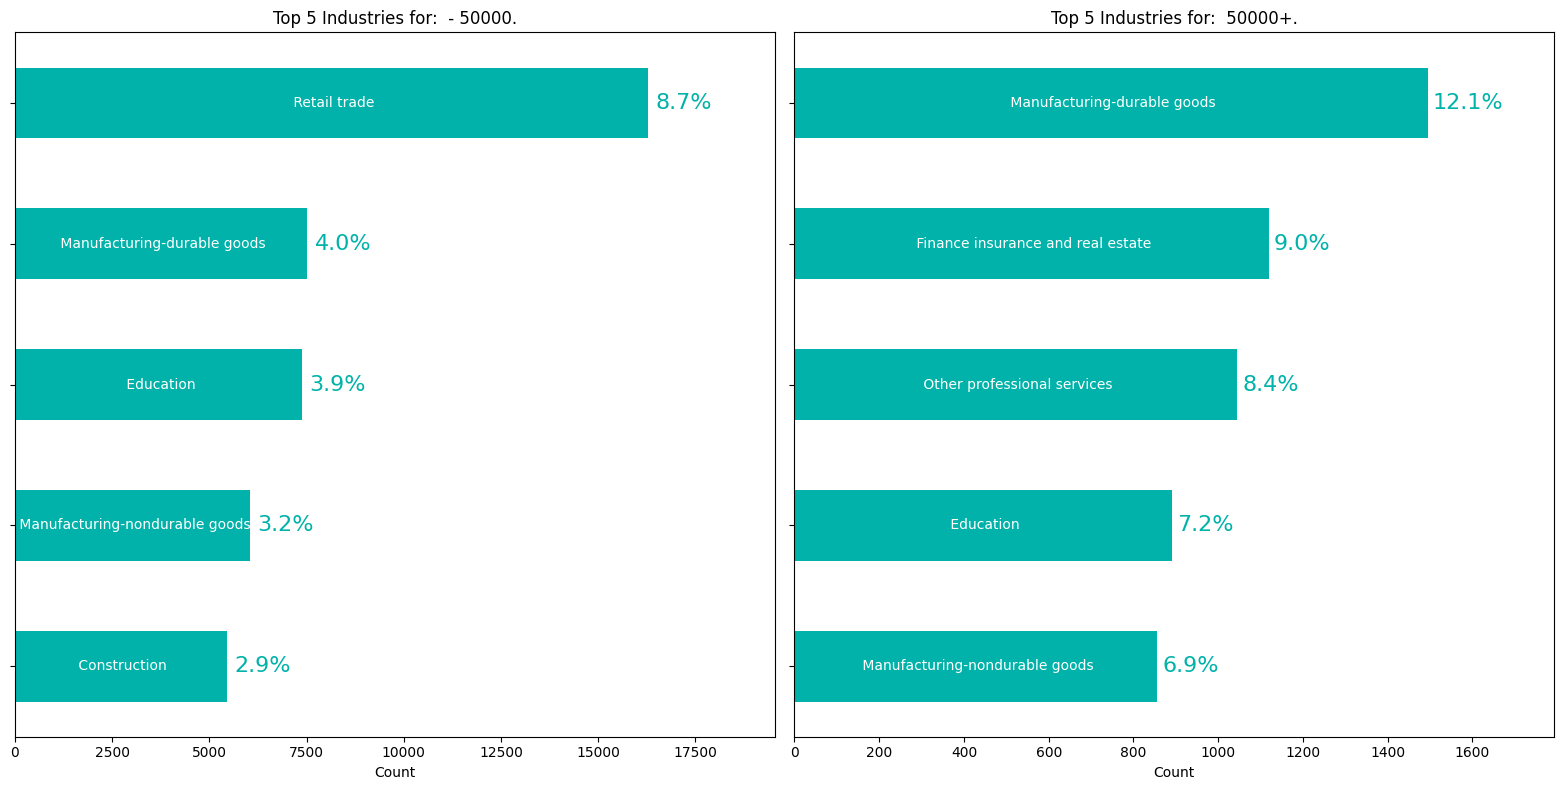

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Split the data based on income
for index, income_value in enumerate(train_raw_df["income"].unique()):
    filtered_data = (
        pd.DataFrame(
            train_raw_df[
                (train_raw_df["major_industry_code"] != " Not in universe or children")
                & (train_raw_df["income"] == income_value)
            ]
            .groupby(["major_industry_code"])
            .count()["age"]
        )
        .sort_values(by="age", ascending=False)
        .head(5)
        .iloc[::-1]
    )

    # Plot the filtered data
    bars = filtered_data.plot(kind="barh", ax=axes[index], color=palette, legend=False)
    axes[index].set_title(f"Top 5 Industries for: {income_value}")

    # Add 20% to xlim
    max_width = max([bar.get_width() for bar in bars.patches])
    axes[index].set_xlim(0, max_width * 1.2)

    # Remove the axis tick labels and title
    axes[index].get_yaxis().set_ticklabels([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('Count')

    # Add text annotation and percentage for each label
    for bar, label in zip(bars.patches, filtered_data.index):
        # Labels
        total = len(train_raw_df[train_raw_df["income"] == income_value])
        percentage = f"{100 * bar.get_width() / total:.1f}%"
        label_text = f"{label}"
        percentage_text = f"{percentage}"

        # Position for labels
        label_x_position = bar.get_width() / 2
        percentage_x_position = bar.get_width() + (total * 0.001)

        # Set the text annotation and percentage for the labels
        axes[index].text(
            label_x_position,
            bar.get_y() + bar.get_height() / 2,
            label_text,
            ha="center",
            va="center",
            color="white",
        )
        axes[index].text(
            percentage_x_position,
            bar.get_y() + bar.get_height() / 2,
            percentage_text,
            ha="left",
            va="center",
            color=palette[0],
            fontsize=16,
        )

plt.tight_layout()
plt.savefig("figures/industry_split.png", dpi=300)
plt.show()


For the lower income, the industry with the highest proportion is Retail Trade while for the highest income It is Manufacturing durable goods. Apart for the first industry, proportion percentages for lower income is evenly distributed. When looking at higher income, we see that percentages are higher, It is become we have a focus on certain industries.

## 2. Data Cleaning


### 2.1 Handling Empty values


In [17]:
# Copy raw dataframe
train_clean_df = train_raw_df.copy()

# Replace "?" with NaN
train_clean_df = train_clean_df.replace([" ?", " Not in universe or children", " Not in universe"], np.nan)

# Check for missing values
if train_clean_df.isnull().values.any():

    # Print the proportion of missing values
    missing_values_count = train_clean_df.isnull().values.sum()
    missing_values_percentage = (
        missing_values_count / train_clean_df.count().sum() * 100
    )
    print(
        f"There are {missing_values_count} empty cells which represents {missing_values_percentage:.2f}% of the dataset.\n"
    )

    # Calculate the percentage of missing values for each column
    nan_percentage = train_clean_df.isnull().mean() * 100

    # Print the columns
    for column, percentage in nan_percentage[nan_percentage > 0].items():
        print(f"Column '{column}': {percentage:.2f}% missing values.")

There are 2076058 empty cells which represents 34.01% of the dataset.

Column 'class_of_worker': 50.24% missing values.
Column 'enroll_in_edu_inst_last_wk': 93.69% missing values.
Column 'major_industry_code': 50.46% missing values.
Column 'major_occupation_code': 50.46% missing values.
Column 'member_of_a_labor_union': 90.45% missing values.
Column 'reason_for_unemployment': 96.96% missing values.
Column 'region_of_previous_residence': 92.09% missing values.
Column 'state_of_previous_residence': 92.45% missing values.
Column 'migration_code-change_in_msa': 50.73% missing values.
Column 'migration_code-change_in_reg': 50.73% missing values.
Column 'migration_code-move_within_reg': 50.73% missing values.
Column 'migration_prev_res_in_sunbelt': 92.09% missing values.
Column 'family_members_under_18': 72.29% missing values.
Column 'country_of_birth_father': 3.36% missing values.
Column 'country_of_birth_mother': 3.07% missing values.
Column 'country_of_birth_self': 1.70% missing values.
C

In [18]:
# Identify columns where the percentage of NaN values is more than 40% and drop them
columns_to_drop = nan_percentage[nan_percentage > 40].index.tolist()
columns_to_impute = nan_percentage[(nan_percentage > 0) & (nan_percentage <= 40)].index

# Drop columns
train_clean_df = train_clean_df.drop(columns=columns_to_drop)
continuous_columns = [c for c in continuous_columns if c not in columns_to_drop]
categorical_columns = [c for c in categorical_columns if c not in columns_to_drop]
print(f"Removed {len(columns_to_drop)} columns: {columns_to_drop}.\n")

# Replace the missing values of the other columns by the most frequent value
for column in columns_to_impute:
    train_clean_df[column] = train_clean_df[column].fillna(
        train_clean_df[column].mode()[0]
    )
    print(f"Imputation on column: {column}.")

# Check that we don't have any missing data anymore
if train_clean_df.isnull().values.any():
    raise Exception("There are missing values remaining!")

Removed 14 columns: ['class_of_worker', 'enroll_in_edu_inst_last_wk', 'major_industry_code', 'major_occupation_code', 'member_of_a_labor_union', 'reason_for_unemployment', 'region_of_previous_residence', 'state_of_previous_residence', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'migration_prev_res_in_sunbelt', 'family_members_under_18', "fill_inc_questionnaire_for_veteran's_admin"].

Imputation on column: country_of_birth_father.
Imputation on column: country_of_birth_mother.
Imputation on column: country_of_birth_self.


### 2.2 Handling Duplicates


In [19]:
# Check and remove duplicates
if train_clean_df.duplicated().values.any():

    # Print the proportion of missing values
    duplicate_rows_count = train_clean_df.duplicated().values.sum()
    duplicate_rows_percentage = duplicate_rows_count / len(train_clean_df) * 100

    print(
        f"There are {duplicate_rows_count} duplicate rows which represents {duplicate_rows_percentage:.2f}% of the dataset."
    )

    # Drop duplicates
    train_clean_df = train_clean_df.drop_duplicates()

There are 52577 duplicate rows which represents 26.35% of the dataset.


### 2.3 Cleaning the Testing Set


In [20]:
# Clean test set
test_clean_df = test_raw_df.copy()
test_clean_df = test_clean_df[continuous_columns + categorical_columns + ["income"]]
test_clean_df = test_clean_df.replace([" ?", " Not in universe or children", " Not in universe"], np.nan)

for c in test_clean_df.columns:
    if c in continuous_columns:
        test_clean_df[c] = test_clean_df[c].fillna(test_clean_df[c].median())
    elif c in categorical_columns:
        test_clean_df[c] = test_clean_df[c].fillna(test_clean_df[c].mode()[0])

## 3. Feature Engineering


In [21]:
# Create feature engineering df
train_fe_df = train_clean_df.copy()
test_fe_df = test_clean_df.copy()

# Print the repartition of the types of features
print(
    f"We have {len(continuous_columns)} continuous columns and {len(categorical_columns)} categorical columns."
)

We have 7 continuous columns and 19 categorical columns.


### 3.1 Feature Creation


We decide to perform Binning on several continuous categories: age, wage per hour and weeks worked in year. We also create a new column total wage for year from 2 existing columns.

In [22]:
def create_labels(bins):
    return (
        [f"<{bins[1]}"]
        + [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(1, len(bins) - 2)]
        + [f"{int(bins[-2])}+"]
    )

def create_grouped_feature(column_name, bins):
    labels = create_labels(bins)
    new_column_name = f"{column_name}_group"
    train_fe_df[new_column_name] = pd.cut(train_fe_df[column_name], bins=bins, labels=labels, right=False)
    test_fe_df[new_column_name] = pd.cut(test_fe_df[column_name], bins=bins, labels=labels, right=False)
    if new_column_name not in categorical_columns:
        categorical_columns.append(new_column_name)

# Defining age bins, labels and apply the operation
name = "age"
bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, np.inf]
create_grouped_feature(name, bins)

# Same for wage_per_hour
name = "wage_per_hour"
bins = [-1, 10, 25, 50, 100, np.inf]
create_grouped_feature(name, bins)

# Same for weeks worked in a year
name = "weeks_worked_in_year"
bins = [-1, 10, 20, 30, 40, np.inf]
create_grouped_feature(name, bins)

# Create a continuous column of the number of weeks worked * wage salary
train_fe_df["total_wage_for_year"] = (
    train_fe_df["weeks_worked_in_year"] * train_fe_df["wage_per_hour"]
)
test_fe_df["total_wage_for_year"] = (
    test_fe_df["weeks_worked_in_year"] * test_fe_df["wage_per_hour"]
)
continuous_columns.append("total_wage_for_year")

# Print the new number of columns
print(
    f"We now have {len(continuous_columns)} continuous columns and {len(categorical_columns)} categorical columns."
)

We now have 8 continuous columns and 22 categorical columns.


### 3.2 Target Variables

In [23]:
# Create a binary output for target variable
y_train = [v == " 50000+." for v in train_clean_df["income"]]
y_test = [v == " 50000+." for v in test_clean_df["income"]]

### 3.3 Continuous Features


We perform feature scaling on continuous features, in particular standardisation (more robust to outliers than normalisation). Then we also check if some features are correlated with a correlation matrix (based on Pearson's coefficients). If there are correlated pairs, we drop 1 of the feature. 

In [24]:
def scale(X_train, X_test):
    # Select columns
    columns = X_train.columns

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Standardize continuous features
    scaled_train_data = scaler.fit_transform(X_train)
    scaled_test_data = scaler.transform(X_test)

    # Convert the arrays to a DataFrames with appropriate column names
    X_train = pd.DataFrame(scaled_train_data, columns=columns)
    X_test = pd.DataFrame(scaled_test_data, columns=columns)

    return X_train, X_test

def correlation_filter(X_train, X_test):
    # Calculate the correlation matrix for continuous features
    corr_matrix = X_train.corr()
    high_corr = corr_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
    high_corr = high_corr[high_corr < 1].iloc[::2]

    # Identifying pairs with high correlation (greater than 0.9) and define columns to drop
    pairs = high_corr[high_corr > 0.9]
    print(f"We have {len(pairs)} pairs of correlated continuous features: {list(pairs.index)}.")

    # Columns to drop
    columns_to_drop = [pair[1] for pair in pairs.index]
    top_features = [feature for feature in X_train.columns if feature not in columns_to_drop]
    print(f"Updated list of continuous features has {len(top_features)} features.")

    # Drop columns
    X_train = X_train[top_features]
    X_test = X_test[top_features]

    return X_train, X_test, top_features

In [25]:
# Continuous dataframes
X_train_continuous, X_test_continuous = scale(
    train_fe_df[continuous_columns], test_fe_df[continuous_columns]
)
X_train_continuous_top, X_test_continuous_top, continuous_columns_top = correlation_filter(
    X_train_continuous, X_test_continuous
)

We have 1 pairs of correlated continuous features: [('total_wage_for_year', 'wage_per_hour')].
Updated list of continuous features has 7 features.


### 3.4 Categorical Features


For categorical features, we perform one hot encoding in order to convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Hence It creates many columns. We than perform Chi-square tests to check if features have an influence on the target variable (significant p value < 0.05). Finally we will only keep the top columns (that have the higher Chi2 values and significant p value) which are the columns supposed to have the more influence on the outcome. 

In [26]:
def one_hot_encode(X_train, X_test):
    # Instantiate the OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Transform both train and test sets
    encoded_train_data = encoder.fit_transform(X_train)
    encoded_test_data = encoder.transform(X_test)

    # Convert the arrays to a DataFrames with appropriate column names
    X_train = pd.DataFrame(encoded_train_data, columns=encoder.get_feature_names_out())
    X_test = pd.DataFrame(encoded_test_data, columns=encoder.get_feature_names_out())

    return X_train, X_test


def chi2_filter(X_train, X_test, n=100):
    # Assuming X and y are already defined and appropriate for chi2
    chi_scores, p_values = chi2(X_train, y_train)

    # Creating a DataFrame with chi-scores, p-values, and feature names
    chi_values_df = pd.DataFrame(
        {"Chi2": chi_scores, "p_value": p_values}, index=X_train.columns
    )

    # Filtering features with significant p-values (p-value < 0.05)
    significant_features = chi_values_df[chi_values_df["p_value"] < 0.05]

    # Sorting the significant features by their Chi-square scores in descending order and selecting
    top_features = (
        significant_features.sort_values(by="Chi2", ascending=False)
        .head(n)
        .index.tolist()
    )

    # Select top features in dataframe
    X_train = X_train[top_features]
    X_test = X_test[top_features]

    return X_train, X_test, top_features, significant_features

In [27]:
# Categorical dataframes
X_train_categorical, X_test_categorical = one_hot_encode(
    train_fe_df[categorical_columns], test_fe_df[categorical_columns]
)

# Top categorical dataframes
X_train_categorical_top, X_test_categorical_top, categorical_columns_top, significant_chi = chi2_filter(
    X_train_categorical, X_test_categorical
)

# Reset indexes to match
X_train_categorical = X_train_categorical.set_index(X_train_continuous.index)
X_test_categorical = X_test_categorical.set_index(X_test_continuous.index)
X_train_categorical_top = X_train_categorical_top.set_index(X_train_continuous.index)
X_test_categorical_top = X_test_categorical_top.set_index(X_test_continuous.index)

Here we plot the top-10 of categorical features having an impact on the target variable according to chi2 tests:

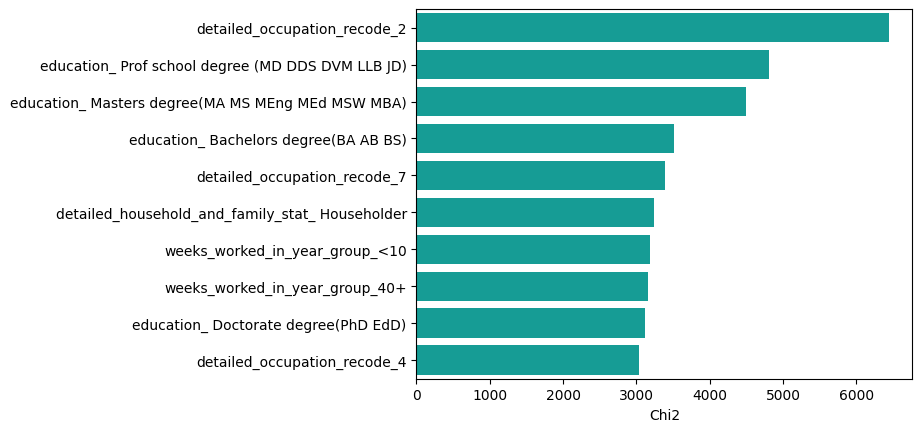

In [28]:
# Key features of importance for predictions 
chi_data = significant_chi.sort_values(by=["Chi2"], ascending=False)[:10]

sns.barplot(chi_data["Chi2"], orient="y", color=palette[0])
plt.savefig("figures/chi_importance.png", dpi=300, bbox_inches='tight')

### 3.5 Combine All Features


Now we need to combine continuous and categorical columns. We create 2 dataframes after standardisation and one hot encoding:
* a dataframe with all the columns 
* a dataframe with redundant continuous columns removed and only the top-100 of categorical features

In [29]:
# Full dataframes
X_train_all = pd.concat([X_train_continuous, X_train_categorical], axis=1)
X_test_all = pd.concat([X_test_continuous, X_test_categorical], axis=1)

# Top dataframes
X_train_top = pd.concat([X_train_continuous_top, X_train_categorical_top], axis=1)
X_test_top = pd.concat([X_test_continuous_top, X_test_categorical_top], axis=1)

### 3.6 Create a balanced dataset

Given the significant imbalance in our dataset, we have prepared two additional datasets through oversampling and downsampling techniques. This approach aims to evaluate whether future models can achieve better performance on these balanced datasets compared to the original unbalanced one.

In [30]:
y_train_df = pd.Series(y_train)

# Combine X and y into a single DataFrame for easier manipulation
data = pd.concat([X_train_all, y_train_df.rename("income")], axis=1)

# Separate majority and minority classes
majority = data[data["income"] == False]
minority = data[data["income"] == True]

#### Downsampling

In downsampling, we randomly reduce the majority class to match the size of the minority class, creating a balanced dataset. This method helps in minimizing the bias towards the majority class, facilitating the development of more generalized models.

In [31]:
# Downsample majority class
majority_downsampled = majority.sample(len(minority), random_state=42)

# Create balanced dataset
downsampled_data = pd.concat([majority_downsampled, minority])
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

# Split the balanced dataset back into X and y
X_train_downsampled = downsampled_data.drop("income", axis=1)
y_train_downsampled = downsampled_data["income"]

print(f"Original dataset size: {len(data)}")
print(f"Balanced dataset size: {len(downsampled_data)}\n")
print(f"Number of True instances: {sum(y_train_downsampled == True)}")
print(f"Number of False instances: {sum(y_train_downsampled == False)}")

Original dataset size: 146946
Balanced dataset size: 24714

Number of True instances: 12357
Number of False instances: 12357


#### Oversampling

In oversampling, we replicate instances from the minority class to equal the majority class's size, thus creating a balanced dataset. This approach enhances the model's ability to learn from the underrepresented class, aiming for a more equitable performance across classes.

In [32]:
# Oversample minority class
minority_oversampled = minority.sample(len(majority), replace=True, random_state=42)

# Create balanced dataset
oversampled_data = pd.concat([majority, minority_oversampled])
oversampled_data = oversampled_data.sample(frac=1, random_state=42)

# Split the balanced dataset back into X and y
X_train_oversampled = oversampled_data.drop("income", axis=1)
y_train_oversampled = oversampled_data["income"]

print(f"Original dataset size: {len(data)}")
print(f"Balanced dataset size: {len(oversampled_data)}\n")
print(f"Number of True instances: {sum(y_train_oversampled == True)}")
print(f"Number of False instances: {sum(y_train_oversampled == False)}")

Original dataset size: 146946
Balanced dataset size: 269178

Number of True instances: 134589
Number of False instances: 134589


### 3.7 PCA


We apply Principal Component Analysis (PCA) to reduce the dimensionality of our dataset while retaining 90% of the variance, aiming to improve model efficiency and prevent overfitting.

In [33]:
# Apply PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance
X_train_pca = pca.fit_transform(X_train_all)
X_test_pca = pca.transform(X_test_all)

## 4. Data Modeling


In [34]:
def predict_with_scores(X, y, model):
    # Predict outcome
    y_pred = model.predict(X)

    # Calculate scores
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    report = classification_report(y, y_pred)

    # Print scores
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}\n")
    print(report)

To rigorously assess the performance of our models, we have created several datasets, each processed differently through downsampling, oversampling, PCA, and feature selection techniques. These datasets are split into training and validation sets first, and then for a better way we create the appropriate training and testing sets.

In [35]:
# Create a validation dataset 
X_train_eval_all, X_eval_all, y_train_eval_all, y_eval_all = train_test_split(X_train_all, y_train, test_size=0.2, random_state=42)
X_train_eval_down, X_eval_down, y_train_eval_down, y_eval_down = train_test_split(X_train_downsampled, y_train_downsampled, test_size=0.2, random_state=42)
X_train_eval_over, X_eval_over, y_train_eval_over, y_eval_over = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.2, random_state=42)
X_train_eval_pca, X_eval_pca, y_train_eval_pca, y_eval_pca = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
X_train_eval_top, X_eval_top, y_train_eval_top, y_eval_top = train_test_split(X_train_top, y_train, test_size=0.2, random_state=42)

# Define different training and testing sets in eval mode
datasets_eval = {
    "Original": (X_train_eval_all, X_eval_all, y_train_eval_all, y_eval_all),
    "Downsampled": (X_train_eval_down, X_eval_down, y_train_eval_down, y_eval_down),
    "Oversampled": (X_train_eval_over, X_eval_over, y_train_eval_over, y_eval_over),
    "PCA": (X_train_eval_pca, X_eval_pca, y_train_eval_pca, y_eval_pca),
    "Top": (X_train_eval_top, X_eval_top, y_train_eval_top, y_eval_top)
}

# Define different training and testing sets in testing mode 
datasets = {
    "Original": (X_train_all, X_test_all, y_train, y_test),
    "Downsampled": (X_train_downsampled, X_test_all, y_train_downsampled, y_test),
    "Oversampled": (X_train_oversampled, X_test_all, y_train_oversampled, y_test),
    "PCA": (X_train_pca, X_test_pca, y_train, y_test),
    "Top": (X_train_top, X_test_top, y_train, y_test)
}

### 4.1 Random Forest

We first train a random forest classifiers on all the datasets to see which one performs better.  Following this, it isolates the best-performing features, highlighting their importance in optimizing the model's predictive accuracy.

In [36]:
# Loop through the datasets, train and test the model on each
for i, d in enumerate([datasets_eval, datasets]):
    mode = "EVAL MODE" if i == 0 else "TEST MODE"
    print(mode)
    for name, (X_train, X_test, y_train, y_test) in d.items():
        print(f"Training Random Forest and testing on {name} dataset")
        
        # Model initialization and fitting
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        
        # Prediction and evaluation
        predict_with_scores(X_test, y_test, rf_model)
        print("\n" + "="*50 + "\n")

EVAL MODE
Training Random Forest and testing on Original dataset


Accuracy: 0.9385
Precision: 0.7334
Recall: 0.3970
F1: 0.5152

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     26972
        True       0.73      0.40      0.52      2418

    accuracy                           0.94     29390
   macro avg       0.84      0.69      0.74     29390
weighted avg       0.93      0.94      0.93     29390



Training Random Forest and testing on Downsampled dataset
Accuracy: 0.8418
Precision: 0.8325
Recall: 0.8573
F1: 0.8447

              precision    recall  f1-score   support

       False       0.85      0.83      0.84      2462
        True       0.83      0.86      0.84      2481

    accuracy                           0.84      4943
   macro avg       0.84      0.84      0.84      4943
weighted avg       0.84      0.84      0.84      4943



Training Random Forest and testing on Oversampled dataset
Accuracy: 0.9824
Precision: 0.9658
Recall: 0.9999
F1: 0.9826

              precision    recall  f1-sc

Random Forest has the best results (in testing mode) when trained on the oversampled dataset.

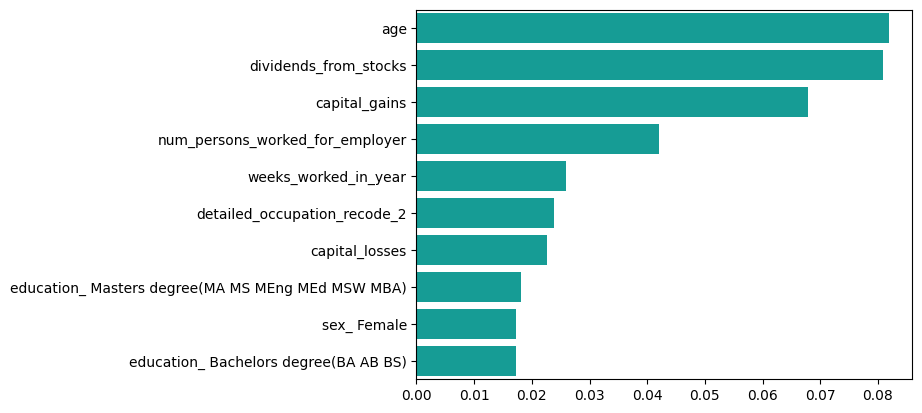

In [37]:
# Feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_all, y_train)

# Get feature importance
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train_all.columns).sort_values(ascending=False).head(10)

# Plot
sns.barplot(forest_importances, orient="y", color=palette[0])
plt.savefig("figures/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()


### 4.2 Logistic Regression

We train a logistic regression model which is a linear approach for modeling the probability of a binary outcome, using a logistic function. 

In [38]:
# Loop through the datasets, train and test the model on each
for i, d in enumerate([datasets_eval, datasets]):
    mode = "EVAL MODE" if i == 0 else "TEST MODE"
    print(mode)
    # Loop through the datasets, train and test the model on each
    for name, (X_train, X_test, y_train, y_test) in d.items():
        print(f"Training Logistic Regression and testing on {name} dataset")
        
        lr_model = LogisticRegression(random_state=42)
        lr_model.fit(X_train, y_train)
        
        # Prediction and evaluation
        predict_with_scores(X_test, y_test, lr_model)
        print("\n" + "="*50 + "\n")

EVAL MODE
Training Logistic Regression and testing on Original dataset


/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9395
Precision: 0.7402
Recall: 0.4078
F1: 0.5259

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     26972
        True       0.74      0.41      0.53      2418

    accuracy                           0.94     29390
   macro avg       0.84      0.70      0.75     29390
weighted avg       0.93      0.94      0.93     29390



Training Logistic Regression and testing on Downsampled dataset


/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8444
Precision: 0.8326
Recall: 0.8638
F1: 0.8479

              precision    recall  f1-score   support

       False       0.86      0.82      0.84      2462
        True       0.83      0.86      0.85      2481

    accuracy                           0.84      4943
   macro avg       0.84      0.84      0.84      4943
weighted avg       0.84      0.84      0.84      4943



Training Logistic Regression and testing on Oversampled dataset


/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8499
Precision: 0.8388
Recall: 0.8644
F1: 0.8514

              precision    recall  f1-score   support

       False       0.86      0.84      0.85     27061
        True       0.84      0.86      0.85     26775

    accuracy                           0.85     53836
   macro avg       0.85      0.85      0.85     53836
weighted avg       0.85      0.85      0.85     53836



Training Logistic Regression and testing on PCA dataset
Accuracy: 0.9341
Precision: 0.7297
Recall: 0.3160
F1: 0.4410

              precision    recall  f1-score   support

       False       0.94      0.99      0.96     26972
        True       0.73      0.32      0.44      2418

    accuracy                           0.93     29390
   macro avg       0.84      0.65      0.70     29390
weighted avg       0.92      0.93      0.92     29390



Training Logistic Regression and testing on Top dataset
Accuracy: 0.9395
Precision: 0.7419
Recall: 0.4053
F1: 0.5242

              precision    recall  f1-score 

/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9535
Precision: 0.7294
Recall: 0.3978
F1: 0.5149

              precision    recall  f1-score   support

       False       0.96      0.99      0.98     93576
        True       0.73      0.40      0.51      6186

    accuracy                           0.95     99762
   macro avg       0.85      0.69      0.75     99762
weighted avg       0.95      0.95      0.95     99762



Training Logistic Regression and testing on Downsampled dataset


/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8766
Precision: 0.3182
Recall: 0.8661
F1: 0.4654

              precision    recall  f1-score   support

       False       0.99      0.88      0.93     93576
        True       0.32      0.87      0.47      6186

    accuracy                           0.88     99762
   macro avg       0.65      0.87      0.70     99762
weighted avg       0.95      0.88      0.90     99762



Training Logistic Regression and testing on Oversampled dataset


/Users/constancegontier/Desktop/Dataiku_technique 2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8793
Precision: 0.3232
Recall: 0.8655
F1: 0.4706

              precision    recall  f1-score   support

       False       0.99      0.88      0.93     93576
        True       0.32      0.87      0.47      6186

    accuracy                           0.88     99762
   macro avg       0.66      0.87      0.70     99762
weighted avg       0.95      0.88      0.90     99762



Training Logistic Regression and testing on PCA dataset
Accuracy: 0.9496
Precision: 0.7120
Recall: 0.3133
F1: 0.4351

              precision    recall  f1-score   support

       False       0.96      0.99      0.97     93576
        True       0.71      0.31      0.44      6186

    accuracy                           0.95     99762
   macro avg       0.83      0.65      0.70     99762
weighted avg       0.94      0.95      0.94     99762



Training Logistic Regression and testing on Top dataset
Accuracy: 0.9531
Precision: 0.7265
Recall: 0.3904
F1: 0.5079

              precision    recall  f1-score 

Logistic Regression has the best results (in testing mode) when trained on the whole dataset as well as in the Top-Features dataset. 

### 4.3 XGBoost

We train an XGBoost algorithm which is an implementation of a gradient boosting that is known for its speed and performance.

In [39]:
def clean_column_names(data):
    if isinstance(data, pd.DataFrame):
        # Replace invalid characters in column names
        clean_names = data.columns.str.replace('[', '_').str.replace(']', '_').str.replace('<', '_')
        data.columns = clean_names
    return data

# Loop through the datasets, train and test the model on each
for i, d in enumerate([datasets_eval, datasets]):
    mode = "EVAL MODE" if i == 0 else "TEST MODE"
    print(mode)
    # Loop through the datasets, train and test the model on each
    for name, (X_train, X_test, y_train, y_test) in d.items():
        print(f"Training XGBoost and testing on {name} dataset")

        # Clean the column names for both training and testing sets to met XGB requirements
        X_train = clean_column_names(X_train.copy())
        X_test = clean_column_names(X_test.copy())
        
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=10,
            use_label_encoder=False,
            eval_metric='logloss'
        )

        # Fit the model on the training data
        xgb_model.fit(X_train, y_train)
        
        # Prediction and evaluation
        predict_with_scores(X_test, y_test, xgb_model)
        print("\n" + "="*50 + "\n")

EVAL MODE
Training XGBoost and testing on Original dataset


Accuracy: 0.9447
Precision: 0.7699
Recall: 0.4677
F1: 0.5819

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     26972
        True       0.77      0.47      0.58      2418

    accuracy                           0.94     29390
   macro avg       0.86      0.73      0.78     29390
weighted avg       0.94      0.94      0.94     29390



Training XGBoost and testing on Downsampled dataset
Accuracy: 0.8535
Precision: 0.8438
Recall: 0.8690
F1: 0.8562

              precision    recall  f1-score   support

       False       0.86      0.84      0.85      2462
        True       0.84      0.87      0.86      2481

    accuracy                           0.85      4943
   macro avg       0.85      0.85      0.85      4943
weighted avg       0.85      0.85      0.85      4943



Training XGBoost and testing on Oversampled dataset
Accuracy: 0.8956
Precision: 0.8800
Recall: 0.9150
F1: 0.8971

              precision    recall  f1-score   suppor

XGBoost has the best results (in testing mode) when trained on the whole dataset.

### 4.4 Neural Network

We build a simple neural network for binary classification with one hidden layer of 10 neurons, utilizing ReLU and sigmoid activation functions to process inputs based on their size and output a single probability score indicating class membership.

In [40]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(input_size, 10)
        self.layer_out = nn.Linear(10, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.sigmoid(self.layer_out(x))
        return x

# Loop through the datasets, train and test the model on each
for i, d in enumerate([datasets_eval, datasets]):
    mode = "EVAL MODE" if i == 0 else "TEST MODE"
    print(mode)
    for name, (X_train, X_test, y_train, y_test) in d.items():
        print(f"Training NN and testing on {name} dataset")
        
        # Check if X_train and X_test are pandas DataFrames and convert accordingly
        if isinstance(X_train, pd.DataFrame):
            X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
            X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
        else:  # Assuming numpy arrays if not pandas DataFrame
            X_train_tensor = torch.tensor(X_train.astype(np.float32))
            X_test_tensor = torch.tensor(X_test.astype(np.float32))
        
        # For y_train and y_test, assuming they're always lists and converting to numpy arrays, then to tensors
        y_train_tensor = torch.tensor(np.array(y_train).astype(np.float32).reshape(-1, 1))
        y_test_tensor = torch.tensor(np.array(y_test).astype(np.float32).reshape(-1, 1))
        
        # Create TensorDatasets and DataLoaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
        
        # Initialize the model
        model = BinaryClassificationModel(X_train.shape[1])
        
        # Loss and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model
        model.train()
        for epoch in range(10):  # 100 epochs
            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            y_pred = (outputs.numpy() > 0.5).astype(int)

        # Calculate scores
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)

        # Print scores
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1: {f1:.4f}\n")
        print(report)
        print("\n" + "="*50 + "\n")

EVAL MODE
Training NN and testing on Original dataset


Accuracy: 0.9395
Precision: 0.7159
Recall: 0.4388
F1: 0.5441

              precision    recall  f1-score   support

       False       0.95      0.98      0.97     26972
        True       0.72      0.44      0.54      2418

    accuracy                           0.94     29390
   macro avg       0.83      0.71      0.76     29390
weighted avg       0.93      0.94      0.93     29390



Training NN and testing on Downsampled dataset
Accuracy: 0.8416
Precision: 0.8573
Recall: 0.8210
F1: 0.8388

              precision    recall  f1-score   support

       False       0.83      0.86      0.84      2462
        True       0.86      0.82      0.84      2481

    accuracy                           0.84      4943
   macro avg       0.84      0.84      0.84      4943
weighted avg       0.84      0.84      0.84      4943



Training NN and testing on Oversampled dataset
Accuracy: 0.8631
Precision: 0.8433
Recall: 0.8901
F1: 0.8661

              precision    recall  f1-score   support

       

The Neural Network built has the best results (in testing mode) when trained on the whole dataset.